# Notebook 3 - Random Forest

In this Notebook:
- Capturing non-linearities ignored by the linear model
- Compare performance
- Analysing what models learn

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from sklearn.inspection import PartialDependenceDisplay

In [16]:
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

RANDOM_STATE = 42
data_path = "../notebooks/data/processed/aapl_calls_ml_dataset.csv"
df = pd.read_csv(data_path, parse_dates=["QUOTE_DATE", "EXPIRE_DATE"])

df.shape, df.head()

((477267, 18),
   QUOTE_DATE EXPIRE_DATE  DTE   T_years      S      K  moneyness  log_moneyness     C_IV  C_DELTA  C_GAMMA   C_VEGA  \
 0 2022-07-01  2022-07-08  7.0  0.027778  138.9   85.0   1.634118       0.491103  0.00048  1.00000  0.00000  0.15666   
 1 2022-07-01  2022-07-08  7.0  0.027778  138.9  100.0   1.389000       0.328584  0.00628  1.00000  0.00000  0.00000   
 2 2022-07-01  2022-07-08  7.0  0.027778  138.9  105.0   1.322857       0.279794  0.75157  0.99524  0.00082  0.00284   
 3 2022-07-01  2022-07-08  7.0  0.027778  138.9  115.0   1.207826       0.188822  0.00037  1.00000  0.00000  0.34662   
 4 2022-07-01  2022-07-08  7.0  0.027778  138.9  117.0   1.187179       0.171580  0.00093  1.00000  0.00000  0.35924   
 
    C_THETA    C_RHO  C_VOLUME  STRIKE_DISTANCE  STRIKE_DISTANCE_PCT  TARGET_PRICE  
 0  0.00000  0.00000       0.0             53.9                0.388        53.900  
 1 -0.00343  0.02150       0.0             38.9                0.280        38.925  
 2 -0.01

## Same as NoteBook2:
- Target
- Features
- Split


In [17]:
# TARGET + FEATURES:
features = ["log_moneyness", "T_years", "C_IV"]
features = [f for f in features if f in df.columns]
greeks = ["C_DELTA", "C_GAMMA", "C_VEGA", "C_THETA", "C_RHO"]
greeks = [g for g in greeks if g in df.columns]

df = df.sort_values("QUOTE_DATE").copy()
y = (df["TARGET_PRICE"] / df["S"]).copy()
X = df[features].copy()  

# TRAIN/TEST SPLIT (time-based):
split_date = pd.Timestamp("2023-01-01")
train_mask = df["QUOTE_DATE"] < split_date
test_mask  = df["QUOTE_DATE"] >= split_date

X_train = X.loc[train_mask]
y_train = y.loc[train_mask]
X_test  = X.loc[test_mask]
y_test  = y.loc[test_mask]

# CHECKS:
assert X_train.index.equals(y_train.index)
assert X_test.index.equals(y_test.index)
print("Train:", X_train.shape, " Test:", X_test.shape)
print("Train dates:", df.loc[train_mask, "QUOTE_DATE"].min(), "->", df.loc[train_mask, "QUOTE_DATE"].max())
print("Test dates:",  df.loc[test_mask,  "QUOTE_DATE"].min(), "->", df.loc[test_mask,  "QUOTE_DATE"].max())


Train: (416329, 3)  Test: (60938, 3)
Train dates: 2021-01-04 00:00:00 -> 2022-12-30 00:00:00
Test dates: 2023-01-03 00:00:00 -> 2023-03-31 00:00:00


## 🌳 Random Forest -
We use a non-linear Random Forest model to capture the non-linearities in option pricing that cannot be modelled by linear regression. Performance will be compared to the linear model studied previously.


- No need to standardise (trees = invariant to changes in scale)
- min_samples_leaf and min_samples_split prevent severe overfitting
- max_features="sqrt" is a good default in RF

In [18]:
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features="sqrt",
    oob_score=True,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

rf.fit(X_train, y_train)
y_pred_train = rf.predict(X_train)
y_pred_test  = rf.predict(X_test)


## Diagnostic -

With a Random Forest, the most interesting graphs are not those that test hypotheses, but those that show where the surface has learned well and where it resists

In [19]:
def regression_report(y_true, y_pred, name=""):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} | RMSE={rmse:.6f}  MAE={mae:.6f}  R2={r2:.6f}")

leaf_counts = []
for tree in rf.estimators_:
    leaves = tree.apply(X_train)
    leaf_counts.append(len(np.unique(leaves)))


regression_report(y_train, y_pred_train, "TRAIN")
regression_report(y_test,  y_pred_test,  "TEST")
print("OOB Score:", rf.oob_score_)
print("Average number of leaves per tree:", np.mean(leaf_counts)) 


TRAIN | RMSE=0.003534  MAE=0.001916  R2=0.999719
TEST | RMSE=0.015072  MAE=0.009098  R2=0.993161
OOB Score: 0.9995097898497725
Average number of leaves per tree: 40648.113333333335


## Back to price

In [20]:
price_true = y_test * df.loc[test_mask, "S"].values
price_pred = y_pred_test * df.loc[test_mask, "S"].values

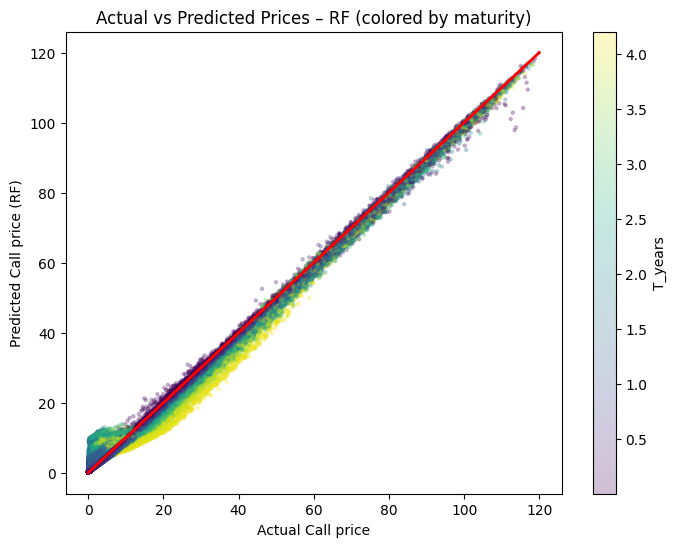

In [21]:

plt.figure(figsize=(8,6))
plt.scatter(price_true, price_pred, c=X_test["T_years"], s=5, alpha=0.25)
lims = [min(price_true.min(), price_pred.min()), max(price_true.max(), price_pred.max())]
plt.plot(lims, lims, 'r-', linewidth=2)
plt.xlabel("Actual Call price")
plt.ylabel("Predicted Call price (RF)")
plt.title("Actual vs Predicted Prices – RF (colored by maturity)")
plt.colorbar(label="T_years")
plt.show()


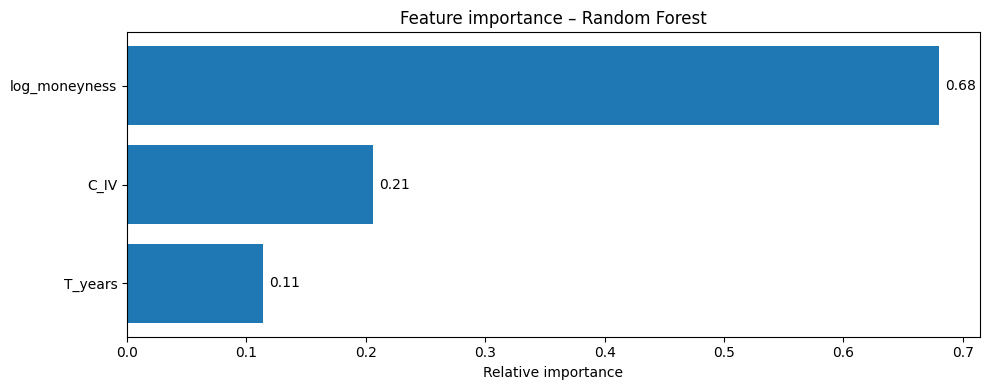

In [22]:
importances = rf.feature_importances_

fi = (
    pd.Series(importances, index=X_train.columns)
    .sort_values(ascending=True))

plt.figure(figsize=(10, 4))
plt.barh(fi.index, fi.values)
plt.xlabel("Relative importance")
plt.title("Feature importance – Random Forest")
for i, v in enumerate(fi.values):
    plt.text(v + 0.005, i, f"{v:.2f}", va="center")
plt.tight_layout()
plt.show()


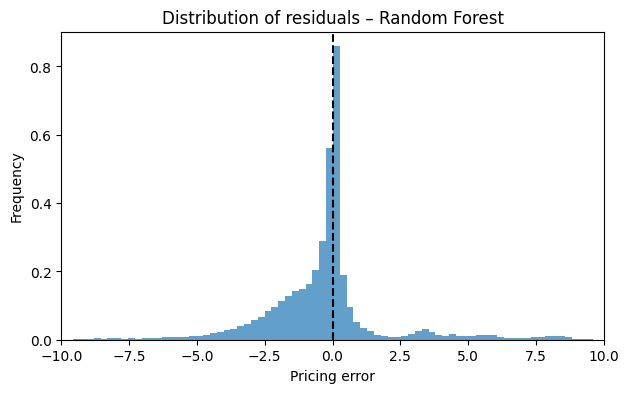

In [23]:
residuals = price_pred - price_true

plt.figure(figsize=(7,4))
plt.hist(residuals, bins=100, density=True, alpha=0.7)
plt.axvline(0, linestyle="--", color="black")
plt.xlim(-10, 10)
plt.title("Distribution of residuals – Random Forest")
plt.xlabel("Pricing error")
plt.ylabel("Frequency")
plt.show()

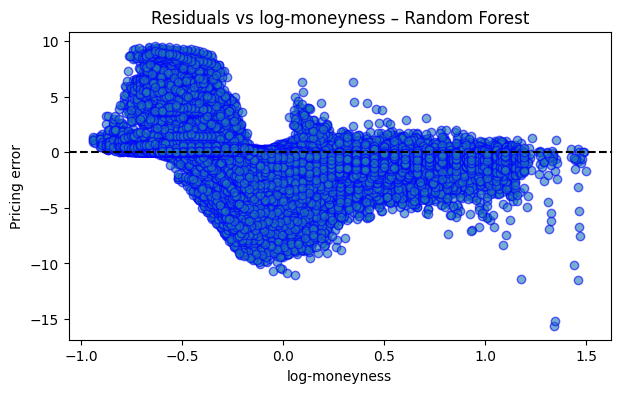

In [24]:
log_m = df.loc[test_mask,"log_moneyness"].values

plt.figure(figsize=(7,4))
plt.scatter(log_m, residuals, edgecolors="blue", alpha=0.6)
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("log-moneyness")
plt.ylabel("Pricing error")
plt.title("Residuals vs log-moneyness – Random Forest")
plt.show()


<Figure size 1000x500 with 0 Axes>

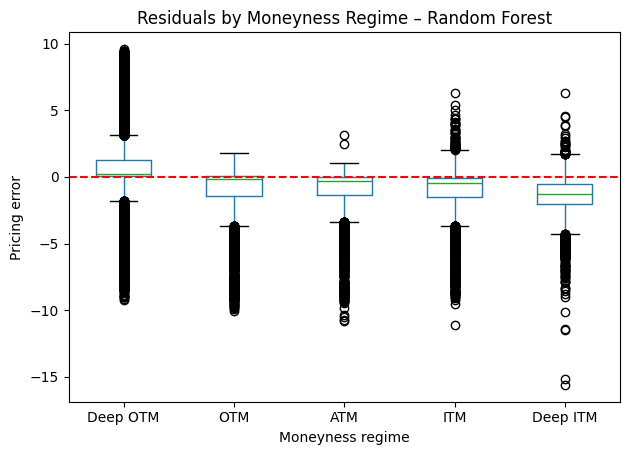

In [25]:
# Construction du DataFrame d'analyse (nom différent de df)
err_moneyness = pd.DataFrame({
    "logM": X_test["log_moneyness"].values,
    "residual": residuals
})

bins = [-np.inf, -0.2, -0.05, 0.05, 0.2, np.inf]
labels = ["Deep OTM", "OTM", "ATM", "ITM", "Deep ITM"]

err_moneyness["moneyness_regime"] = pd.cut(
    err_moneyness["logM"],
    bins=bins,
    labels=labels
)

# Boxplot des résidus par régime
plt.figure(figsize=(10, 5))
err_moneyness.boxplot(
    column="residual",
    by="moneyness_regime",
    grid=False
)

plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals by Moneyness Regime – Random Forest")
plt.suptitle("")
plt.xlabel("Moneyness regime")
plt.ylabel("Pricing error")
plt.tight_layout()
plt.show()